<a href="https://colab.research.google.com/github/VatsalyaDubey16/Transfer_Learning_Models/blob/main/Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning: Fine-tuning
---

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.15.0


In [3]:
import datetime
print(f"The slide last run (end-to-end): {datetime.datetime.now()}")

The slide last run (end-to-end): 2024-03-19 09:50:43.350129


## Creating helper function

In [4]:
!wget https://raw.githubusercontent.com/VatsalyaDubey16/Transfer_Learning_Models/main/helper_functions.py

--2024-03-19 09:50:43--  https://raw.githubusercontent.com/VatsalyaDubey16/Transfer_Learning_Models/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-19 09:50:43 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-03-19 09:50:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   149MB/s    in 1.1s    

2024-03-19 09:50:45 (149 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [8]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

While using`image_dataset_from_directory` there is no need to use `ImageDataGenerator` and `flow_from_directory`

In [9]:
# Turn our data into batches of tensors
IMG_SIZE =(224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE )

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = 'categorical',
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
# None = 32, No.of classes = 10
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[  7.1283484    8.128348     3.128348  ]
   [  5.670759     6.670759     1.670759  ]
   [  6.0725446    6.8694196    2.4787946 ]
   ...
   [ 37.46875     27.46875      0.98102665]
   [ 38.587055    28.587053     1.6149554 ]
   [ 38.49107     28.491072     1.8761162 ]]

  [[  7.           8.           3.        ]
   [  7.           8.           3.        ]
   [  4.8113837    5.6082587    1.2176338 ]
   ...
   [ 40.166298    33.166298     5.2232156 ]
   [ 37.928574    30.928572     2.9285717 ]
   [ 39.772324    32.772324     4.7723217 ]]

  [[  6.           7.           2.        ]
   [  5.785714     6.785714     1.7857141 ]
   [  4.8404016    5.6372766    1.2466518 ]
   ...
   [ 68.24554     61.24554     33.24554   ]
   [ 50.86496     43.86496     15.864958  ]
   [ 51.895092    44.895092    16.895092  ]]

  ...

  [[  2.           2.           2.        ]
   [  2.           2.           2.        ]
   [  3.           3.           1.        ]
   ...
   [155.80925    146.809

* Functional API is more flexible

In [13]:
# 1. Create base model using tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name ='input_layer')

# 4. Pass the input to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs throguh base model: {x.shape}")

# 6. Average pool the outputs of the base model(getting the import feature from the above layer)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name ='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25*len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name = "tensorboard_hub",
                                                                          experiment_name = "model_0")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs throguh base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tensorboard_hub/model_0/20240319-095057
Epoch 1/5
24/24 [==============================] - 23s 305ms/step - loss: 1.8936 - accuracy: 0.4013 - val_loss: 1.3320 - val_accuracy: 0.6974
Epoch 2/5
24/24 [==============================] - 4s 133ms/step - loss: 1.1164 - accuracy: 0.7680 - val_loss: 0.8886 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 4s 135ms/step - loss: 0.7958 - accuracy: 0.8293 - val_loss: 0.7054 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 5s 176ms/step - loss: 0.6493 - accuracy: 0.8533 - val_loss: 0.6288 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 4s 131ms/step - loss: 0.5600 - accuracy: 0.8693 - val_loss: 0.5843 - val_accuracy: 0.8405


In [14]:
len(train_data_10_percent)

24

In [15]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.5575 - accuracy: 0.8648


[0.5574589967727661, 0.864799976348877]

In [16]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [17]:
# Summary of base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [18]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

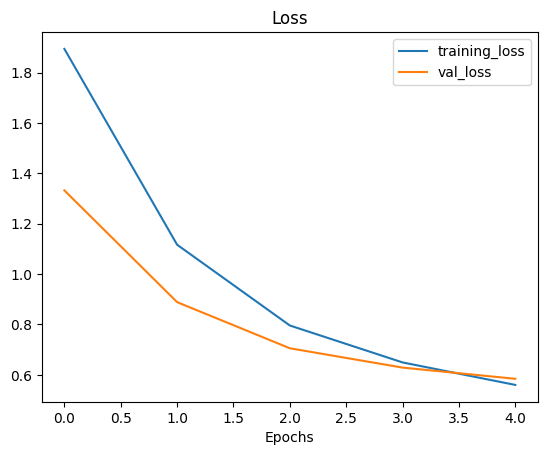

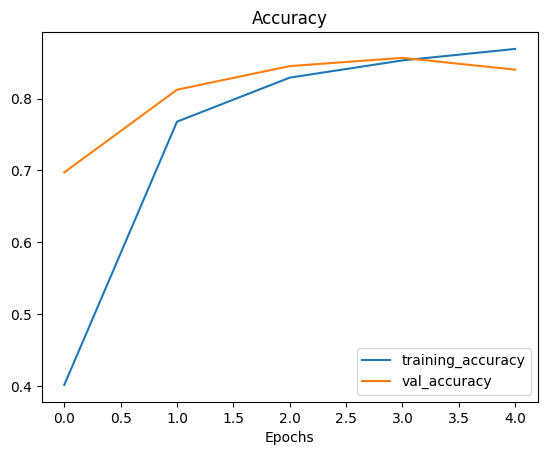

In [19]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector
* Converting tensor into vector
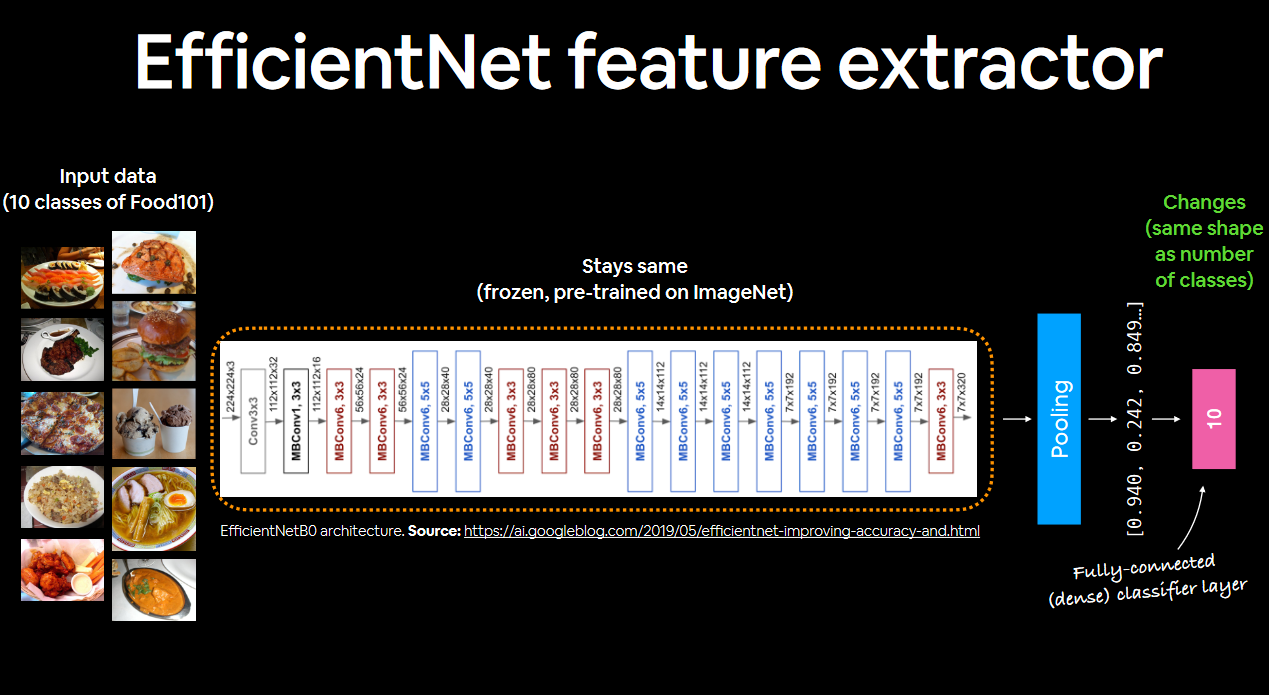

In [20]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor throguh a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D tensor: (1, 3)


In [21]:
# Replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis= [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

1. `model_1` : use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` : use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` : use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` : use fine-tuning transfer learning on 100% of the training data with data augmentation

In [22]:
# Download and unzip data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-03-19 09:51:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.207, 209.85.145.207, 172.217.219.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   101MB/s    in 1.3s    

2024-03-19 09:51:58 (101 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [24]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [25]:
# Setup data
IMG_SIZE = (224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = 'categorical',
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
---
* We are creating a layer for our *Functional API* model using *Sequential layer*

* Preprocessing on ImageDataGenerator happens on the CPU

* While below augmentation happens on the GPU

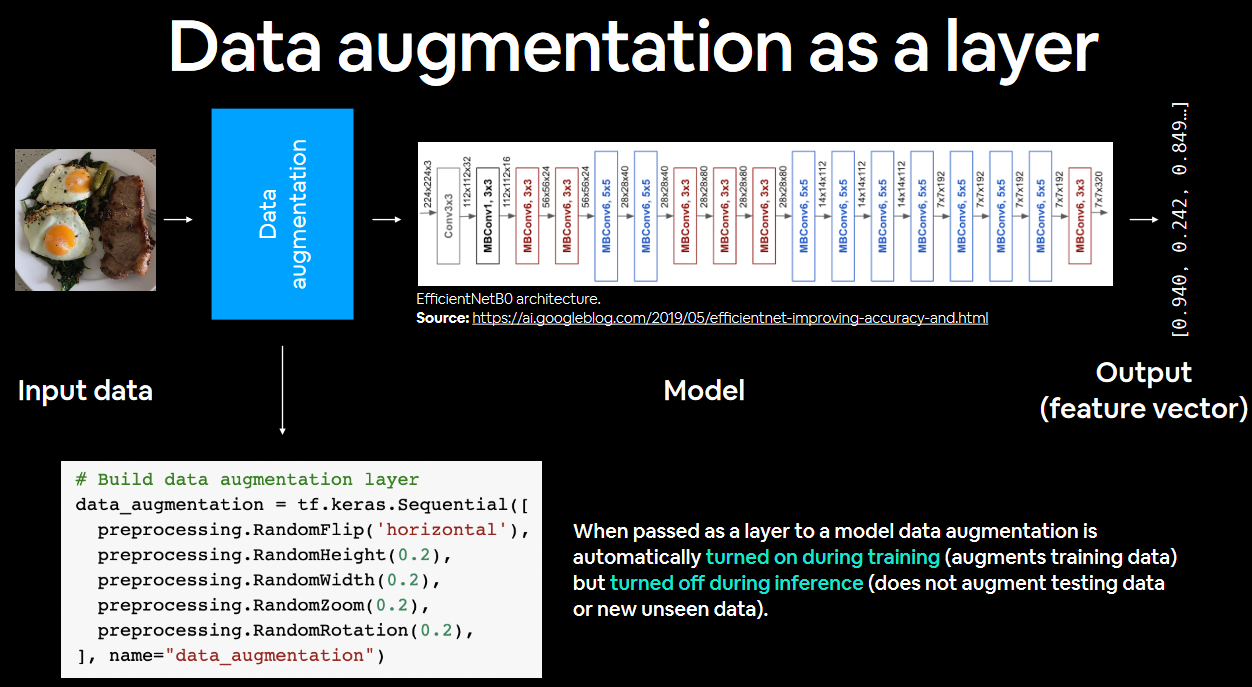

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name = 'data_augmetation')

## Visualize our data augmentation layer(and see what happens to our data)
---

10_food_classes_1_percent/train/fried_rice
228039.jpg
[[[113  43   9]
  [107  37   1]
  [110  36   1]
  ...
  [244 223 192]
  [244 223 192]
  [244 223 192]]

 [[106  33   0]
  [123  50  15]
  [149  75  38]
  ...
  [245 224 193]
  [245 224 193]
  [245 224 193]]

 [[138  64  27]
  [166  92  53]
  [198 120  81]
  ...
  [246 225 196]
  [246 227 197]
  [246 227 197]]

 ...

 [[151  76  44]
  [134  59  27]
  [152  77  45]
  ...
  [ 61  23   4]
  [ 65  27   8]
  [ 63  25   6]]

 [[137  63  28]
  [141  67  32]
  [162  86  52]
  ...
  [ 59  20   3]
  [ 63  24   7]
  [ 61  22   5]]

 [[131  57  20]
  [148  74  37]
  [165  89  55]
  ...
  [ 59  20   3]
  [ 62  23   6]
  [ 61  22   5]]]
 Dimension of the augmented image : (1, 431, 524, 3)



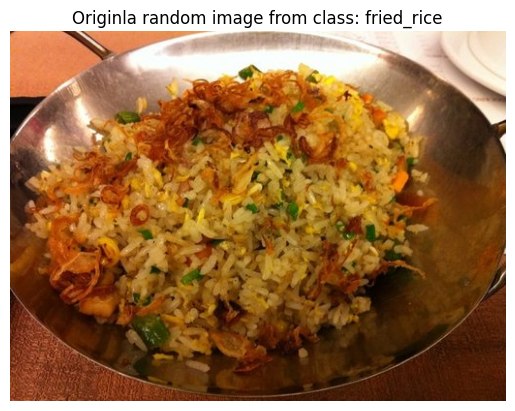

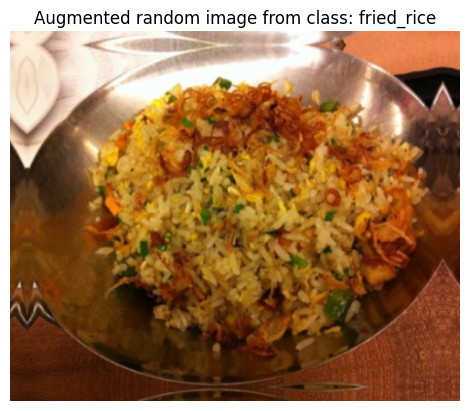

In [27]:
# View a random image and compare it to its augmented version
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image)

# Read in thr random image
img = mpimg.imread(random_image_path)
print(img)
plt.title(f"Originla random image from class: {target_class}")
plt.imshow(img)
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
augmented_img = augmented_img/255.
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
print(f" Dimension of the augmented image : {augmented_img.shape}\n")
plt.imshow(tf.squeeze((augmented_img)));


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [28]:
# Setup input shape and base model , freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input layer
inputs =  layers.Input(shape = input_shape, name ='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# Put a dense layers on as the output
outputs = layers.Dense(10, activation = "softmax", name = 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics =['accuracy'])

# Fit the model
history_10_percent = model_1.fit(train_data_1_percent,
                                 epochs =5,
                                 steps_per_epoch = len(train_data_1_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25*len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name = "tensorboard_hub",
                                                                          experiment_name = "model_0")])

Saving TensorBoard log files to: tensorboard_hub/model_0/20240319-095207
Epoch 1/5
3/3 [==============================] - 23s 3s/step - loss: 2.4816 - accuracy: 0.0429 - val_loss: 2.2490 - val_accuracy: 0.1546
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.2573 - accuracy: 0.1571 - val_loss: 2.1335 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 1.9761 - accuracy: 0.2857 - val_loss: 2.0196 - val_accuracy: 0.3174
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8453 - accuracy: 0.4429 - val_loss: 1.9043 - val_accuracy: 0.4062
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6744 - accuracy: 0.6000 - val_loss: 1.8120 - val_accuracy: 0.4605


In [29]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmetation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [30]:
# Evaluate on the full dataset
model_1.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 1.8320 - accuracy: 0.4352


[1.8319810628890991, 0.4352000057697296]

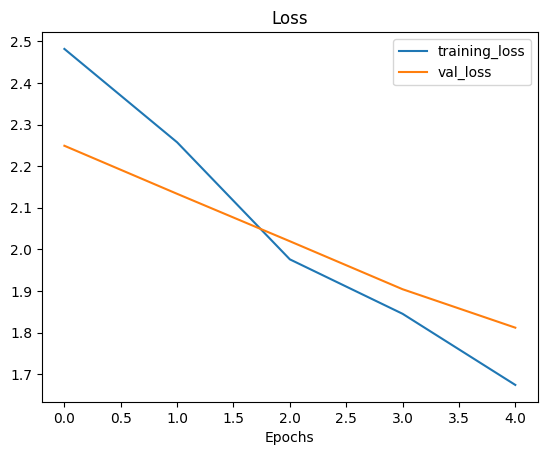

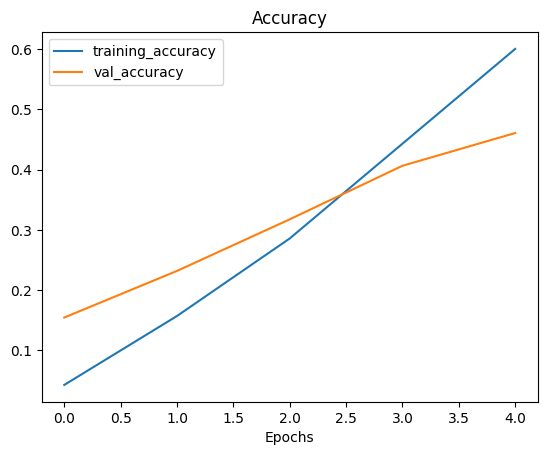

In [31]:
# Loss curve
plot_loss_curves(history_10_percent)

## Model 2: Feature extraction transfer learning with data augmentation with 10% data

In [32]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test/'

In [33]:
# Set data inputs

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = 'categorical',
                                                                            image_size = IMG_SIZE,
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
# Create model 2 with data augmentation
from tensorflow.keras import layers

# Build data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
])

# Setup the input shape to our model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the inputs and outputs (including layers in between)
inputs = layers.Input(shape = input_shape, name = 'input_layer')
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training = False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name = "global-average_pooling_2D")(x)
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


In [35]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global-average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (5

In [36]:
# Check for batchNormalization layer
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, None, None, 3)        0         ['normalization_2

## Model check point callback

> The ModelCheckpoint callback intermediately saves our model(the full or just the weights) durint trainin. This is useful so we can come and start where we left off.

In [37]:
# Set checkpoinpt path
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch", # save every epoch
                                                         verbose = 1)

### Fit model 2 passing in the ModelCheckpoint callback

In [38]:
# Fit the model saving checkpoints every epoch
initial_epoch = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epoch,
                                          validation_data = test_data,
                                          validation_steps = int(0.25*len(test_data)),
                                          callbacks =[create_tensorboard_callback(dir_name = "tensorboard_hub",
                                                                          experiment_name = "model_0"),
                                                      checkpoint_callback])

Saving TensorBoard log files to: tensorboard_hub/model_0/20240319-095316
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9960 - accuracy: 0.3227
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 33s 1s/step - loss: 1.9960 - accuracy: 0.3227 - val_loss: 1.4307 - val_accuracy: 0.6645
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3271 - accuracy: 0.6907
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 862ms/step - loss: 1.3271 - accuracy: 0.6907 - val_loss: 0.9824 - val_accuracy: 0.7977
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0063 - accuracy: 0.7560
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 828ms/step - loss: 1.0063 - accuracy: 0.7560 - val_loss: 0.7985 - val_accuracy: 0.8273
Epoch 4/5
24/24 [=

In [39]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 63ms/step - loss: 0.5575 - accuracy: 0.8648


[0.5574589371681213, 0.864799976348877]

In [40]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 76ms/step - loss: 0.6204 - accuracy: 0.8448


[0.6203653216362, 0.8447999954223633]

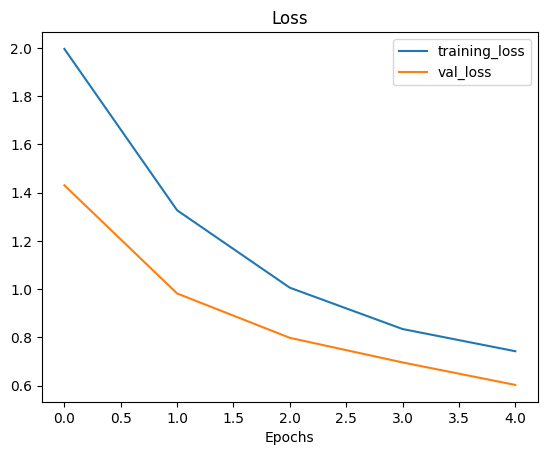

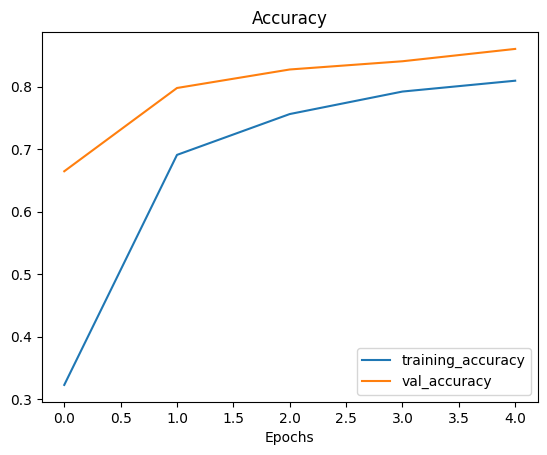

In [41]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

## Loading in checkpointed weights
> Loading in checkpointed weights returns a model to a specified checkpoint

In [42]:
# Load in the saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [43]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6204 - accuracy: 0.8448


In [44]:
# If the results form our previously evaluted model_2 match the loaded weights,
results_10_percent_data_aug == loaded_weights_model_results

False

In [45]:
results_10_percent_data_aug

[0.6203653216362, 0.8447999954223633]

In [46]:
loaded_weights_model_results

[0.6203653812408447, 0.8447999954223633]

In [47]:
# Check to see if loaded model results are very close to our previouse non-loaded model results
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [48]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


## Model 3: Fine-tuning
> Fine-tuning usually best after training a feature extraction model for a few epochs with large amount of custom data

In [49]:
# Layers in loaded model
model_2.layers

In [50]:
# Are thees layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7a7b0e719780> True
<keras.src.engine.sequential.Sequential object at 0x7a7b07626680> True
<keras.src.engine.functional.Functional object at 0x7a7b07c676a0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7a7b07c64460> True
<keras.src.layers.core.dense.Dense object at 0x7a7b07c0a620> True


In [51]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [52]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [53]:
# To begin fine-tuning, let's start by setting the last 10 layersr of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss ='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001), # when fine-tuning you typically want to lower the learning by 10x
                metrics = ['accuracy'])

In [54]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [57]:
# Check unfrozen layers
print(len(model_2.trainable_variables))

12


In [58]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epoch + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fint_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25*len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],# -1 starts from last. Start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                        experiment_name = "10_percent_fine_tune_last_10_layers")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10_layers/20240319-095703
Epoch 5/10
24/24 [==============================] - 33s 905ms/step - loss: 0.7322 - accuracy: 0.7587 - val_loss: 0.4808 - val_accuracy: 0.8553
Epoch 6/10
24/24 [==============================] - 20s 805ms/step - loss: 0.3905 - accuracy: 0.8813 - val_loss: 0.4722 - val_accuracy: 0.8372
Epoch 7/10
24/24 [==============================] - 17s 660ms/step - loss: 0.2321 - accuracy: 0.9280 - val_loss: 0.4207 - val_accuracy: 0.8618
Epoch 8/10
24/24 [==============================] - 21s 855ms/step - loss: 0.1785 - accuracy: 0.9547 - val_loss: 0.4012 - val_accuracy: 0.8750
Epoch 9/10
24/24 [==============================] - 18s 718ms/step - loss: 0.1132 - accuracy: 0.9680 - val_loss: 0.4711 - val_accuracy: 0.8586
Epoch 10/10
24/24 [==============================] - 18s 733ms/step - loss: 0.0672 - accuracy: 0.9773 - val_loss: 0.4762 - val_accuracy: 0.8635


In [59]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.4773 - accuracy: 0.8608


In [63]:
# Model_2 accuracy
results_10_percent_data_aug

[0.6203653216362, 0.8447999954223633]

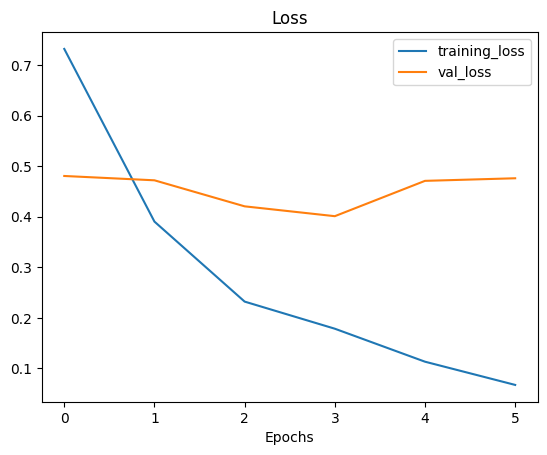

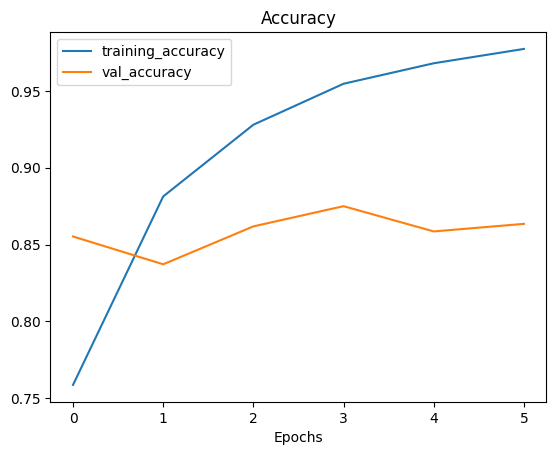

In [65]:
# Chekc out the loss curve
plot_loss_curves(history_fint_10_percent_data_aug)

> The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [72]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs = 5):
  """
  Compare two Tensorflow History objects
  """
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss+ new_history.history['val_loss']

  # Make plots
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label ="Training Accuracy")
  plt.plot(total_val_acc, label = "Val Accuracy")
  # -1 as it starts from 0
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend()
  plt.title("Training and Validation Accuracy")

  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss, label ="Training Loss")
  plt.plot(total_val_loss, label = "Val Loss")
  # -1 as it starts from 0
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend()
  plt.title("Training and Validation Loss")


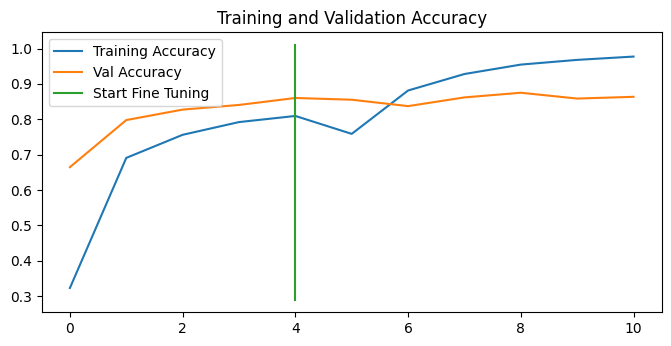

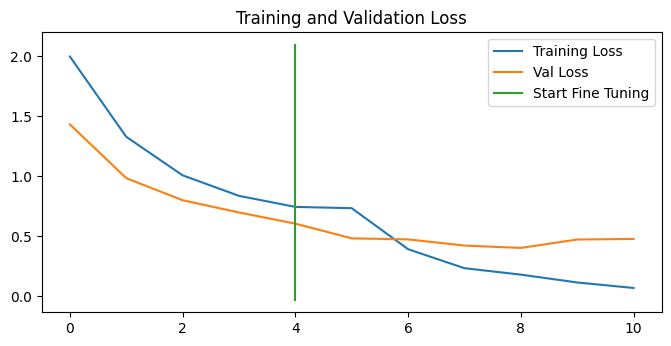

In [73]:
compare_historys(original_history = history_10_percent_data_aug,
                 new_history = history_fint_10_percent_data_aug,
                 initial_epochs = 5)